In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import SineCosineDataset
from tiny.utils import plot_point_cloud, plot_point_clouds, count_parameters
from tiny import Diffusion, PointCloudDDPM, PointCloudDiffusionTrainer, UnconditionalPointCloudDiT

In [3]:
dataset = SineCosineDataset(type="sine", num_points=32)
dataloader = DataLoader(dataset, collate_fn=dataset.collate, batch_size=128)

In [4]:
diffusion = Diffusion(schedule_type="linear", num_timesteps=250, learn_sigma=False)
dit = UnconditionalPointCloudDiT(input_size=32, in_channels=2, depth=1, num_heads=1, hidden_size=128)
# dit = MLP(hidden_size=128, hidden_layers=10, emb_size=128).to("cuda")
ddpm = PointCloudDDPM(dit, diffusion)

In [5]:
count_parameters(dit)

380674

In [6]:
trainer = PointCloudDiffusionTrainer(
    ddpm,
    dataloader,
    num_epochs=10000 * 2,
    lr=1e-3
)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [01:26<00:00, 230.76it/s, loss=0.178]


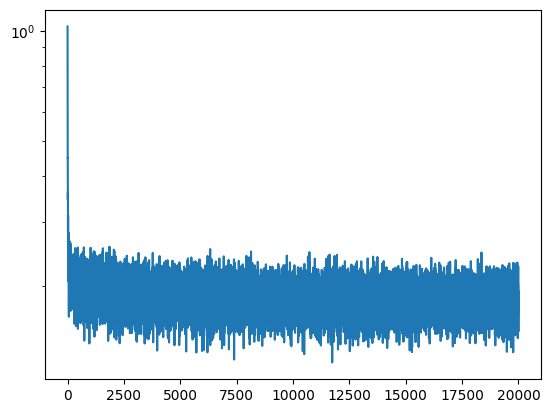

In [7]:
losses = trainer.train()
plt.semilogy(losses)

Sampling:  37%|███▋      | 93/250 [00:00<00:00, 921.56it/s]

Sampling: 100%|██████████| 250/250 [00:00<00:00, 922.20it/s]


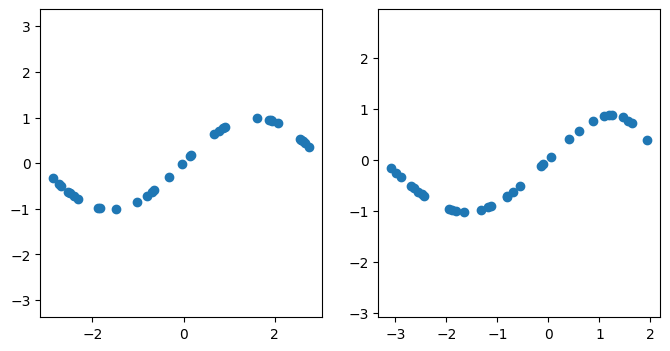

In [23]:
sample = diffusion.p_sample_loop(dit, (2, 32, 2), clip_denoised=False)
plot_point_clouds(sample, 1, 2)

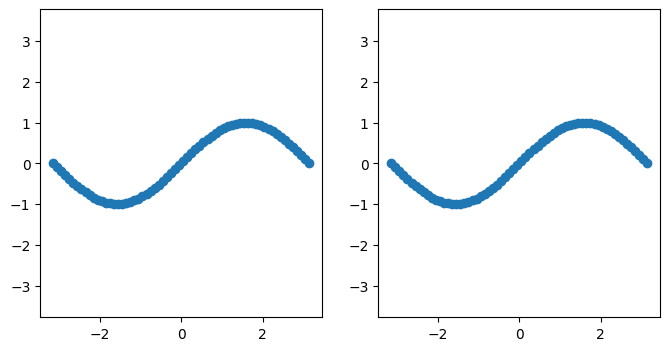

In [ ]:
plot_point_clouds(batch["data"], 1, 2)